In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re

In [36]:
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.metrics import classification_report

In [75]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [92]:
from sklearn.linear_model import LogisticRegression

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 2.3 MB/s eta 0:00:06
     --- ------------------------------------ 1.3/12.8 MB 10.2 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 24.3 MB/s eta 0:00:01
     ----------------- ---------------------- 5.6/12.8 MB 25.3 MB/s eta 0:00:01
     --------------------- ------------------ 6.9/12.8 MB 25.9 MB/s eta 0:00:01
     ------------------------- -------------- 8.0/12.8 MB 25.6 MB/s eta 0:00:01
     ------------------------------ --------- 9.8/12.8 MB 27.2 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 34.4 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 34.4 MB/s eta 0:00:01
     ---------------------------------- ---- 11.2/12.8 MB 27.3 MB/s eta 0:00:01
     ------------------------------------- - 12.2

#### Carga de datos

In [8]:
df = pd.read_csv("sentimentdataset.csv")

In [5]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15


In [10]:
df = df.drop(columns=["Unnamed: 0.1","Unnamed: 0"])

In [16]:
df.sample(3)

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
170,"Anxiety grips my heart, worry clouds my thoug...",Anxiety,2019-04-15 09:00:00,WorriedMind,Instagram,#Anxiety #Worry,12.0,25.0,UK,2019,4,15,9
333,Navigating through the challenges with determi...,Determination,2023-10-12 10:30:00,GoalPursuer,Twitter,#Determination #Challenges,15.0,30.0,Canada,2023,10,12,10
8,Political discussions heating up on the timel...,Negative,2023-01-17 08:00:00,DebateTalk,Twitter,#Politics #Debate,30.0,60.0,USA,2023,1,17,8


In [14]:
df.shape

(732, 13)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       732 non-null    object 
 1   Sentiment  732 non-null    object 
 2   Timestamp  732 non-null    object 
 3   User       732 non-null    object 
 4   Platform   732 non-null    object 
 5   Hashtags   732 non-null    object 
 6   Retweets   732 non-null    float64
 7   Likes      732 non-null    float64
 8   Country    732 non-null    object 
 9   Year       732 non-null    int64  
 10  Month      732 non-null    int64  
 11  Day        732 non-null    int64  
 12  Hour       732 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 74.5+ KB


In [18]:
df.Sentiment.unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

In [19]:
def map_sentiment(value):
    positive_sentiments = ['Happiness', 'Joy', 'Love', 'Amusement', 'Enjoyment', 'Admiration', 'Affection', 
                           'Awe', 'Surprise', 'Acceptance', 'Adoration', 'Anticipation', 'Elation', 'Euphoria', 
                           'Contentment', 'Serenity', 'Gratitude', 'Hopeful', 'Empathy', 'Compassion', 'Empathetic', 
                           'Compassionate', 'Inspired', 'Confidence', 'Zest', 'Grateful', 'Empowering', 'Reverence', 
                           'Fulfillment', 'Blessed', 'Blessed', 'Optimism', 'Reflection', 'Inspiration', 'Wonder', 
                           'Pride', 'Playful', 'Gratitude', 'Positive', 'Success', 'Adventure', 'Happiness', 'Enlightened']
    
    negative_sentiments = ['Anger', 'Fear', 'Sadness', 'Disgust', 'Frustration', 'Boredom', 'Anxiety', 'Intimidation', 
                           'Helplessness', 'Jealousy', 'Resentment', 'Regret', 'Loneliness', 'Grief', 'Despair', 'Loneliness', 
                           'Frustration', 'Anxiety', 'Intimidation', 'Helplessness', 'Jealousy', 'Bitterness', 'Despair', 
                           'Frustrated', 'Envious', 'Fearful', 'Apprehensive', 'Overwhelmed', 'Devastated', 'Dismissive', 
                           'Shame', 'Guilt', 'Frustration', 'Envy', 'Isolation', 'Sorrow', 'Heartbreak', 'Disappointment', 
                           'Melancholy', 'Exhaustion', 'Regret', 'Heartache', 'Grief', 'Desperation', 'Suffering', 'Darkness', 
                           'Betrayal', 'Desolation']
    
    neutral_sentiments = ['Neutral', 'Confusion', 'Numbness', 'Indifference', 'Ambivalence', 'Curiosity', 'Calmness', 
                          'Solitude', 'Reflection', 'Resilience', 'Acceptance', 'Pensive', 'Loneliness', 'Tired', 
                          'Bitter', 'Solace', 'Alone', 'EmotionalStorm']
    
    if value.strip() in positive_sentiments:
        return 'Positive'
    elif value.strip() in negative_sentiments:
        return 'Negative'
    elif value.strip() in neutral_sentiments:
        return 'Neutral'
    else:
        return 'Neutral'  

df['Sentiment'] = df['Sentiment'].apply(map_sentiment)

In [20]:
df.sample(5)

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
485,"Floating on clouds of gratitude, each raindrop...",Positive,2016-12-10 21:15:00,CloudsOfBlessings,Facebook,#Gratitude #ShowerOfThankfulness,28.0,55.0,Germany,2016,12,10,21
665,Planning a surprise scavenger hunt for friends...,Neutral,2023-08-24 18:20:00,ScavengerHuntMasterHighSchool,Instagram,#SurpriseAdventure #HighSchoolFun,20.0,38.0,UK,2023,8,24,18
535,"At the Oscars, the actor graciously accepts an...",Positive,2016-02-28 20:30:00,AwardWinningActorOscarsRecipient,Facebook,#Gratitude #OscarWinningMoment,18.0,35.0,USA,2016,2,28,20
54,Heartbroken after hearing the news about a na...,Negative,2023-02-12 14:45:00,EmpathyFirst,Facebook,#Sadness #NaturalDisaster,25.0,50.0,India,2023,2,12,14
537,"As the movie credits roll, the viewer experien...",Neutral,2019-11-05 21:15:00,FilmBuffContemplativeViewer,Instagram,#Contemplation #DeepMeanings,28.0,55.0,Germany,2019,11,5,21


In [22]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [23]:
df_copy = df.copy()

#### Preprocesamiento de los datos

In [24]:
df.shape

(732, 13)

In [25]:
df = df[["Text","Sentiment"]]

In [26]:
df

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,Positive
1,Traffic was terrible this morning. ...,Neutral
2,Just finished an amazing workout! 💪 ...,Positive
3,Excited about the upcoming weekend getaway! ...,Positive
4,Trying out a new recipe for dinner tonight. ...,Neutral
...,...,...
727,Collaborating on a science project that receiv...,Neutral
728,Attending a surprise birthday party organized ...,Neutral
729,Successfully fundraising for a school charity ...,Neutral
730,"Participating in a multicultural festival, cel...",Neutral


In [27]:
X = df["Text"]
y = df["Sentiment"]

In [49]:
X_train

395       dazzle elegance masquerade ball dazzle costume
549    witness heartwarming comeback hockey final fan...
716    collaborate group project promote teamwork sha...
451    haunt specter lose possibility ghost refuse fa...
442          labyrinth grief wall echo footstep lose joy
                             ...                        
221    flip page old yearbook nostalgia paint smile t...
484    lose maze curiosity twist turn unveil treasure...
486    like comet inspiration streak sky creativity l...
213    embrace flaw find acceptance imperfection jour...
333                     navigate challenge determination
Name: Text, Length: 512, dtype: object

In [32]:
y

0      Positive
1       Neutral
2      Positive
3      Positive
4       Neutral
         ...   
727     Neutral
728     Neutral
729     Neutral
730     Neutral
731     Neutral
Name: Sentiment, Length: 732, dtype: object

In [41]:
y.value_counts(normalize=True)*100

Sentiment
 0    44.808743
 1    37.431694
-1    17.759563
Name: proportion, dtype: float64

In [34]:
mapping = {"Negative":-1 , "Neutral":0 , "Positive": 1}
y = y.map(mapping)

In [35]:
y

0      1
1      0
2      1
3      1
4      0
      ..
727    0
728    0
729    0
730    0
731    0
Name: Sentiment, Length: 732, dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [42]:
def limpieza(texto):
    texto = texto.lower()    
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    doc = nlp(texto)
    texto_limpio = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return texto_limpio

In [43]:
def sentyment_textblob(texto):
    blob = TextBlob(texto)
    return blob.sentiment.polarity

In [45]:
nlp = spacy.load("en_core_web_sm")

In [47]:
X_train = X_train.apply(limpieza)

In [50]:
X_test = X_test.apply(limpieza)

In [51]:
y_train_pred = X_train.apply(sentyment_textblob)
y_test_pred = X_test.apply(sentyment_textblob)

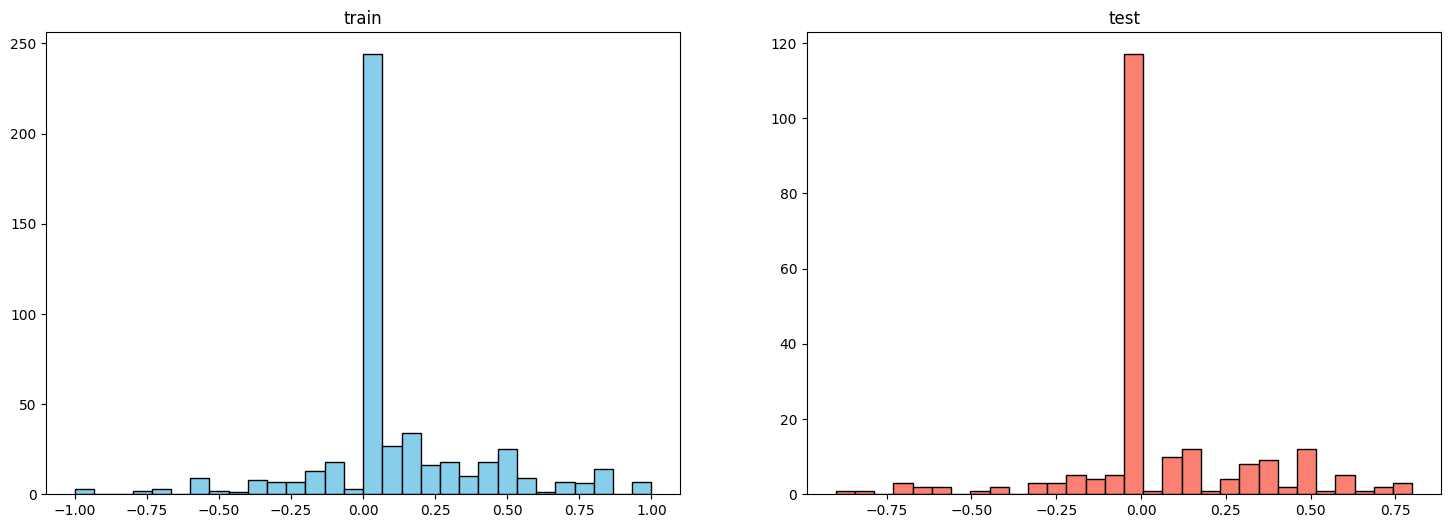

In [56]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.hist(y_train_pred, bins=30, color="skyblue", edgecolor="black")
plt.title("train")

plt.subplot(1,2,2)
plt.hist(y_test_pred, bins=30, color="salmon", edgecolor="black")
plt.title("test")
plt.show()

In [57]:
y_train_pred.describe()

count    512.000000
mean       0.096646
std        0.305223
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.203571
max        1.000000
Name: Text, dtype: float64

In [59]:
y_test_pred.mode()

0    0.0
Name: Text, dtype: float64

In [64]:
y_train_pred

395    0.0
549    0.3
716    0.1
451    0.0
442    0.0
      ... 
221    0.2
484    0.0
486    0.0
213    0.0
333    0.0
Name: Text, Length: 512, dtype: float64

In [62]:
def clasificar_sentimiento(polaridad):
    if polaridad > 0:
        return 1
    elif polaridad < 0:
        return -1
    else:
        return 0

In [67]:
y_train_pred = y_train_pred.apply(clasificar_sentimiento)

In [68]:
y_test_pred = y_test_pred.apply(clasificar_sentimiento)

In [70]:
print("reporte para train")
print(classification_report(y_train, y_train_pred))
print("----------------------")
print("reporte para test")
print(classification_report(y_test, y_test_pred))

reporte para train
              precision    recall  f1-score   support

          -1       0.43      0.36      0.40        91
           0       0.42      0.43      0.42       229
           1       0.49      0.52      0.50       192

    accuracy                           0.45       512
   macro avg       0.45      0.44      0.44       512
weighted avg       0.45      0.45      0.45       512

----------------------
reporte para test
              precision    recall  f1-score   support

          -1       0.47      0.38      0.42        39
           0       0.46      0.55      0.50        99
           1       0.46      0.40      0.43        82

    accuracy                           0.46       220
   macro avg       0.47      0.44      0.45       220
weighted avg       0.46      0.46      0.46       220



#### BoW + Bayes

In [84]:
X_train

395       dazzle elegance masquerade ball dazzle costume
549    witness heartwarming comeback hockey final fan...
716    collaborate group project promote teamwork sha...
451    haunt specter lose possibility ghost refuse fa...
442          labyrinth grief wall echo footstep lose joy
                             ...                        
221    flip page old yearbook nostalgia paint smile t...
484    lose maze curiosity twist turn unveil treasure...
486    like comet inspiration streak sky creativity l...
213    embrace flaw find acceptance imperfection jour...
333                     navigate challenge determination
Name: Text, Length: 512, dtype: object

In [85]:
X_test

312    overwhelm cacophony expectation drown soul tem...
596    spontaneously book weekend getaway adventure a...
181           frustration boil volcanic eruption emotion
545    cheer underdog basketball final crowd erupt ap...
151                             contentment embrace love
                             ...                        
432      heartache deepen solitary journey abyss despair
460    void heartache echo love song play note pang l...
53                  feel sense fear watch thriller movie
17                       latenight gaming session friend
161                 reverence wonder nature hiking trail
Name: Text, Length: 220, dtype: object

In [76]:
vectorizer = CountVectorizer()

In [77]:
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [78]:
X_train_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4031 stored elements and shape (512, 1713)>

In [79]:
X_test_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1272 stored elements and shape (220, 1713)>

In [80]:
model = MultinomialNB()

In [81]:
model.fit(X_train_bow, y_train)

MultinomialNB()

In [82]:
y_train_pred = model.predict(X_train_bow)
y_test_pred = model.predict(X_test_bow)

In [83]:
print("reporte para train")
print(classification_report(y_train, y_train_pred))
print("----------------------")
print("reporte para test")
print(classification_report(y_test, y_test_pred))

reporte para train
              precision    recall  f1-score   support

          -1       0.94      0.98      0.96        91
           0       0.96      0.93      0.94       229
           1       0.95      0.96      0.96       192

    accuracy                           0.95       512
   macro avg       0.95      0.96      0.95       512
weighted avg       0.95      0.95      0.95       512

----------------------
reporte para test
              precision    recall  f1-score   support

          -1       0.88      0.77      0.82        39
           0       0.72      0.72      0.72        99
           1       0.70      0.76      0.73        82

    accuracy                           0.74       220
   macro avg       0.77      0.75      0.76       220
weighted avg       0.75      0.74      0.74       220



#### TF-IDF + RL

In [86]:
vectorizer = TfidfVectorizer()

In [88]:
X_train_tf_idf = vectorizer.fit_transform(X_train)

In [89]:
X_test_tf_idf = vectorizer.transform(X_test)

In [93]:
model = LogisticRegression(random_state=1)

In [94]:
model.fit(X_train_tf_idf, y_train)

LogisticRegression(random_state=1)

In [95]:
y_train_pred = model.predict(X_train_tf_idf)
y_test_pred = model.predict(X_test_tf_idf)

In [96]:
print("reporte para train")
print(classification_report(y_train, y_train_pred))
print("----------------------")
print("reporte para test")
print(classification_report(y_test, y_test_pred))

reporte para train
              precision    recall  f1-score   support

          -1       1.00      0.86      0.92        91
           0       0.93      0.99      0.96       229
           1       0.98      0.97      0.98       192

    accuracy                           0.96       512
   macro avg       0.97      0.94      0.95       512
weighted avg       0.96      0.96      0.96       512

----------------------
reporte para test
              precision    recall  f1-score   support

          -1       1.00      0.38      0.56        39
           0       0.63      0.86      0.73        99
           1       0.77      0.66      0.71        82

    accuracy                           0.70       220
   macro avg       0.80      0.63      0.66       220
weighted avg       0.75      0.70      0.69       220

